This file is used to generate Fig S5

In [25]:
from model import PModel, PIP

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

#Global parameters for Pareto front
n_loci = 9      #Number of loci
p1 = 0.3        #Probability of first-order epistatic interaction
p2 = 0.3        #Probability of second-order epistatic interaction
sigma1 = 0.3    #Standard deviation for first-order epistasis
sigma2 = 0.3    #Standard deviation for second-order epistasis
beta = 0.005    #Baseline transmission rate

In [26]:
#Initialize discrete random loci model
cost = np.random.exponential(0.1, n_loci)
res = np.random.exponential(0.1, n_loci)

PF_model = PModel(n_loci, res, cost, beta=beta)
PF_model.normalize()

res_pareto, fec_pareto = PF_model.pareto()
res_linear, fec_linear = PF_model.linear_approx(points=1000)
res_cubic, fec_cubic, _ = PF_model.poly_approx(order=3, points=1000)

PIP_pareto = PIP(res_pareto, fec_pareto)
PIP_linear = PIP(res_linear, fec_linear)
PIP_cubic = PIP(res_cubic, fec_cubic)

In [27]:
def label_x_ticks(ax, vals, n_ticks = 4):
    x_lim = ax.get_xlim()
    x_ticks = np.linspace(x_lim[0], x_lim[1], n_ticks)
    x_tick_labels = np.round(np.linspace(np.min(vals), np.max(vals), n_ticks), 3)

    ax.set_xticks(x_ticks, x_tick_labels)

def label_y_ticks(ax, vals, n_ticks = 4):
    y_lim = ax.get_ylim()
    y_ticks = np.linspace(y_lim[0], y_lim[1], n_ticks)
    y_tick_labels = np.round(np.linspace(np.min(vals), np.max(vals), n_ticks), 3)

    ax.set_yticks(y_ticks, y_tick_labels)

### Code to generate the graphics for Figure S5

Text(0, 0.5, 'Mutant Transmission Rate ($\\beta_m$)')

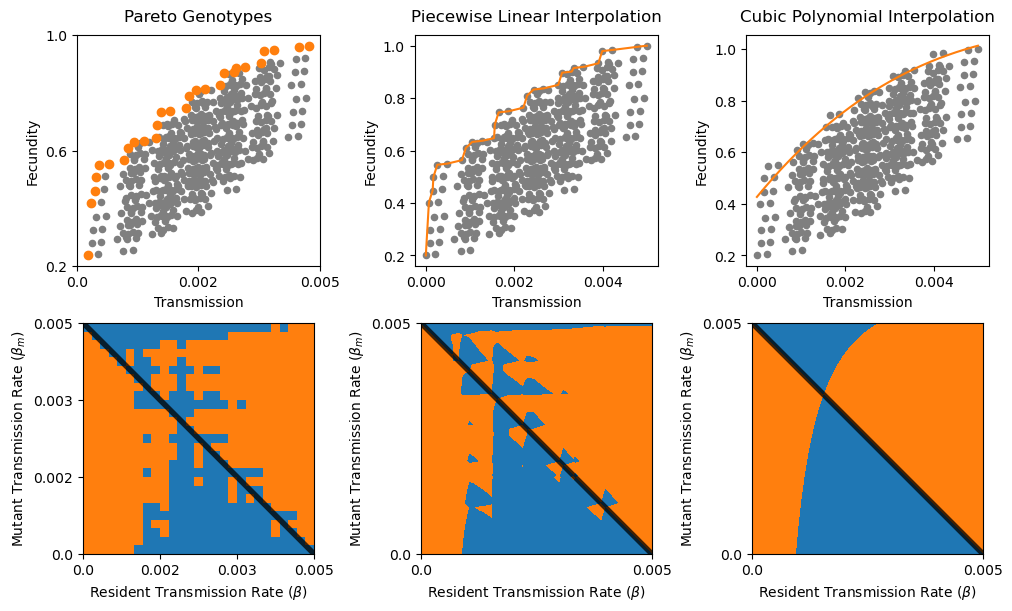

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), layout='constrained')

### Figure 3A: Genotype distribution scatterplot ###
ax[0,0].scatter(PF_model.B, PF_model.F, c='tab:gray', s=20)
ax[0,0].scatter(res_pareto, fec_pareto, c='tab:orange')

ax[0,0].set_title('Pareto Genotypes', pad=10)
ax[0,0].set_ylabel('Fecundity')
ax[0,0].set_xlabel('Transmission')

label_x_ticks(ax[0,0], PF_model.B, 3)
label_y_ticks(ax[0,0], PF_model.F, 3)

### Figure 3B: Genotype distribution plot with piecewise linear interpolation ###
ax[0,1].scatter(PF_model.B, PF_model.F, c='tab:gray', s=20)
ax[0,1].plot(res_linear, fec_linear, color='tab:orange')

ax[0,1].set_title('Piecewise Linear Interpolation', pad=10)
ax[0,1].set_ylabel('Fecundity')
ax[0,1].set_xlabel('Transmission')

### Figure 3C: Genotype distribution plot with cubic interpolation ###
ax[0,2].scatter(PF_model.B, PF_model.F, c='tab:gray', s=20)
ax[0,2].plot(res_cubic, fec_cubic, color='tab:orange')

ax[0,2].set_title('Cubic Polynomial Interpolation', pad=10)
ax[0,2].set_ylabel('Fecundity')
ax[0,2].set_xlabel('Transmission')

cmap = matplotlib.colors.ListedColormap(['tab:blue','tab:orange'])

### Figure 3D: PIP plot for the Pareto genotypes ###
ax[1,0].imshow(PIP_pareto.T, cmap=cmap)

lims_1 = [
    np.min([ax[1,0].get_xlim(), ax[1,0].get_ylim()]),
    np.max([ax[1,0].get_xlim(), ax[1,0].get_ylim()]),
]

ax[1,0].plot(lims_1, lims_1, 'k-', alpha=0.75, zorder=0, linewidth=4)

label_x_ticks(ax[1,0], PF_model.B)
label_y_ticks(ax[1,0], PF_model.B)

ax[1,0].set_xlabel(r'Resident Transmission Rate ($\beta$)')
ax[1,0].set_ylabel(r'Mutant Transmission Rate ($\beta_m$)')

### Figure 3E: PIP plot for the piecewise linear interpolated genotypes ###
ax[1,1].imshow(PIP_linear.T, cmap=cmap)

lims_2 = [
    np.min([ax[1,1].get_xlim(), ax[1,1].get_ylim()]),
    np.max([ax[1,1].get_xlim(), ax[1,1].get_ylim()]),
]

ax[1,1].plot(lims_2, lims_2, 'k-', alpha=0.75, zorder=0, linewidth=4)

label_x_ticks(ax[1,1], PF_model.B, n_ticks=2)
label_y_ticks(ax[1,1], PF_model.B, n_ticks=2)

ax[1,1].set_xlabel(r'Resident Transmission Rate ($\beta$)')
ax[1,1].set_ylabel(r'Mutant Transmission Rate ($\beta_m$)')

### Figure 3F: PIP plot for the cubic polynomial interpolated genotypes ###
ax[1,2].imshow(PIP_cubic.T, cmap=cmap)

lims_3 = [
    np.min([ax[1,2].get_xlim(), ax[1,2].get_ylim()]),
    np.max([ax[1,2].get_xlim(), ax[1,2].get_ylim()]),
]

ax[1,2].plot(lims_3, lims_3, 'k-', alpha=0.75, zorder=0, linewidth=4)

label_x_ticks(ax[1,2], PF_model.B, n_ticks=2)
label_y_ticks(ax[1,2], PF_model.B, n_ticks=2)

ax[1,2].set_xlabel(r'Resident Transmission Rate ($\beta$)')
ax[1,2].set_ylabel(r'Mutant Transmission Rate ($\beta_m$)')